In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import gzip
import os
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')

2024-04-10 13:14:07.130265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 13:14:07.130404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 13:14:07.257056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "/kaggle/input/mnist-image/MNIST/MNIST - JPG - training"
test_dir = "/kaggle/input/mnist-image/MNIST/MNIST - JPG - testing"

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(label_folder, filename)
                    image = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
                    image_array = img_to_array(image)
                    images.append(image_array)
                    labels.append(int(label))
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

In [4]:

print("Number of train images:", len(train_images))
print("Number of train labels:", len(train_labels))
print("Number of test images:", len(test_images))
print("Number of test labels:", len(test_labels))

Number of train images: 60000
Number of train labels: 60000
Number of test images: 10000
Number of test labels: 10000


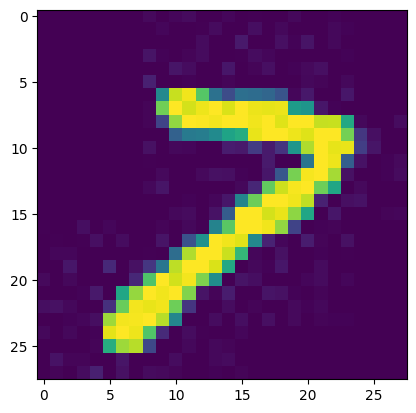

In [5]:
plt.imshow(test_images[0])

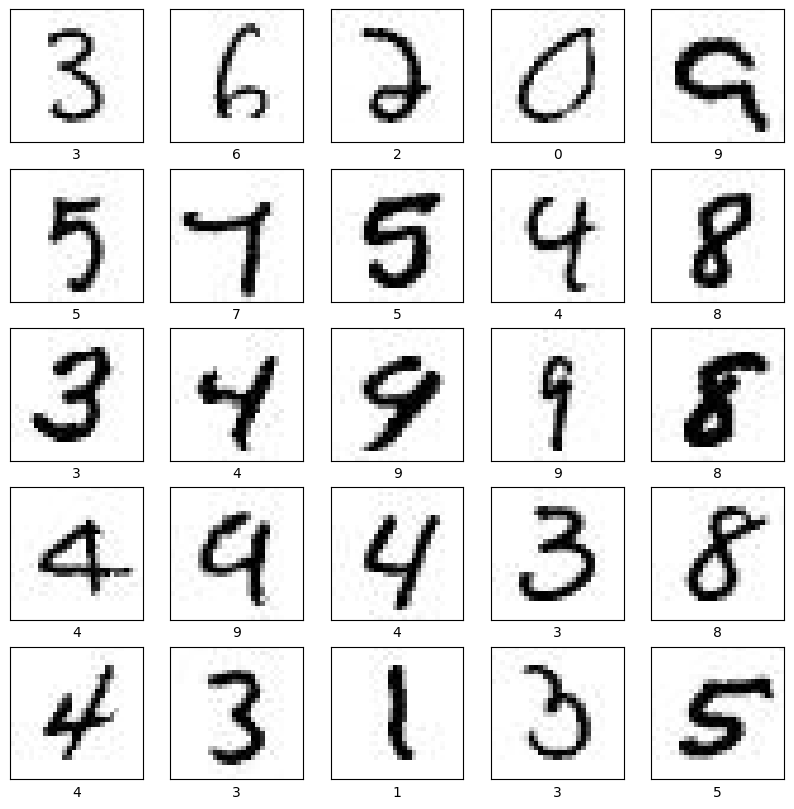

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    rand_index = np.random.randint(0, len(train_images))
    plt.imshow(train_images[rand_index], cmap=plt.cm.binary)
    plt.xlabel(train_labels[rand_index])
plt.show()

In [7]:

print("Shape of training images:", train_images.shape)
print("Shape of testing images:", test_images.shape) 
print("Shape of testing labels:", test_labels.shape)
print("Shape of training labels:", train_labels.shape)


Shape of training images: (60000, 28, 28, 1)
Shape of testing images: (10000, 28, 28, 1)
Shape of testing labels: (10000,)
Shape of training labels: (60000,)


In [8]:

from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

train_images=train_images/255.0
test_images=test_images/255.0
val_images = val_images / 255.0

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Add

def residual_block(x, filters, downsample=False):
    strides = 1
    if downsample:
        strides = 2
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    y = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    if downsample:
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = tf.keras.layers.add([x, y])
    out = Activation('relu')(out)
    return out

inputs = Input(shape=(28, 28, 1))
x = Conv2D(64, 7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(3, strides=2, padding='same')(x)

num_blocks_list = [2, 2, 2, 2]
for i, num_blocks in enumerate(num_blocks_list):
    for j in range(num_blocks):
        downsample = False
        if j == 0 and i != 0:
            downsample = True
        x = residual_block(x, 64 * (2 ** i), downsample)

x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 7, 7, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 7, 64)  │          0 │ max_pooling2d[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 7, 7, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 7, 64)  │          0 │ activation_2[0][… │
│                     │                   │            │ batch_normalizat

 Total params: 13,079,434 (49.89 MB)

 Trainable params: 13,071,626 (49.86 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels))

Epoch 1/50
   7/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.2744 - loss: 3.3284

I0000 00:00:1712755084.464548      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712755084.508687      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8746 - loss: 0.5044

W0000 00:00:1712755105.621776      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.8747 - loss: 0.5041 - val_accuracy: 0.9636 - val_loss: 0.1520
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9739 - loss: 0.1024 - val_accuracy: 0.9612 - val_loss: 0.1381
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9773 - loss: 0.0889 - val_accuracy: 0.9772 - val_loss: 0.0847
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9785 - loss: 0.1080 - val_accuracy: 0.9827 - val_loss: 0.0702
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9870 - loss: 0.0566 - val_accuracy: 0.9794 - val_loss: 0.0906
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9866 - loss: 0.0507 - val_accuracy: 0.9813 - val_loss: 0.0806
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9843 - loss: 0.0674 - val_accuracy: 0.9423 - val_loss: 0.5710
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9843 - loss: 0.07

In [11]:

test_loss, test_accuracy = model.evaluate(test_images,test_labels)
print("Test Accuracy:", test_accuracy)

 40/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0589

W0000 00:00:1712756097.375925      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9915 - loss: 0.0650
Test Accuracy: 0.9926000237464905


W0000 00:00:1712756100.551125      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


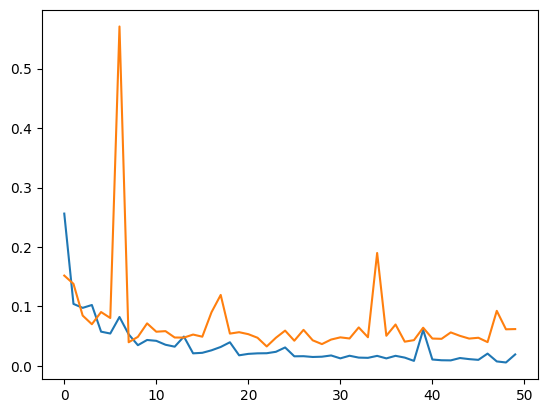

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

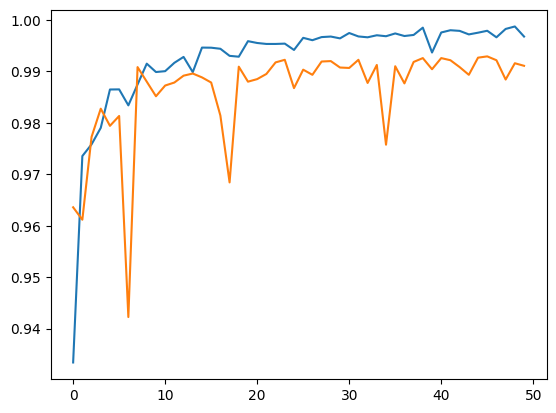

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


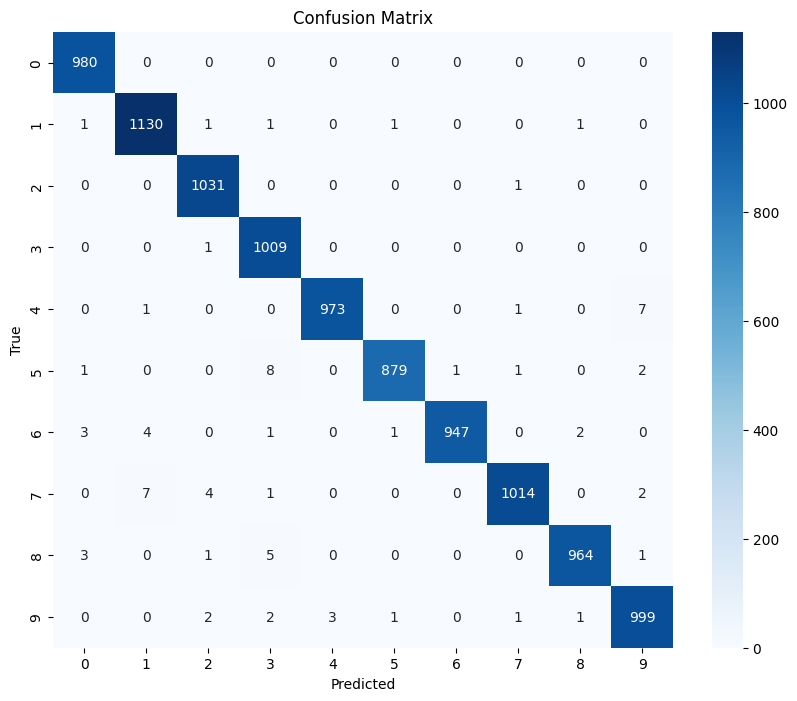

In [14]:
y_pred = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:

probabilities = model.predict(test_images)

predicted_classes = np.argmax(probabilities, axis=-1)
predicted_classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([7, 7, 7, ..., 6, 6, 6])

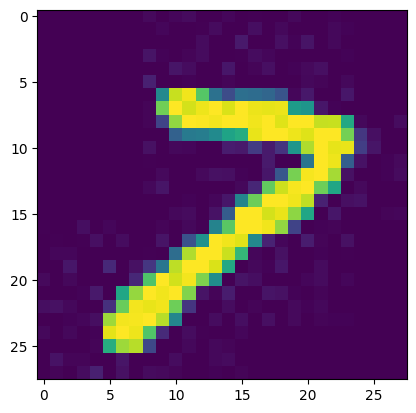

In [16]:
plt.imshow(test_images[0])